In [1]:
# Polynomials, StaticArrays, OffsetArrays, LinearAlgebra, SparseArrays, StringBuilders, Revise
import Pkg
using LinearAlgebra
using SparseArrays
using NLsolve
using Dates
using Revise
using Polynomials
using Profile
using DelimitedFiles
import Base.@kwdef
myreaddlm(filename) = readdlm(filename, comments=true, comment_char='%');

In [2]:
cd("..")
pwd()

"/home/ebenq/Dev/julia/low_d_models"

In [3]:
includet("src/BasisFunctions.jl")
includet("src/BifurcationGenerator.jl")
includet("src/Hookstep.jl")
includet("src/tw_newton.jl")
includet("src/VelocityGraphs.jl")
includet("src/TWBifurcations.jl")

using .BasisFunctions
using .BifurcationGenerator
using .Hookstep
using .TW_Newton
using .TWBifurcations

Velocity field visualization functions loaded!

Available functions:
  - velocity_fields(Ψ, solution; save_path=...)
  - velocity_fields_dns(root; save_path=...)
  - velocity_fields_comparison(Ψ, solution, root; save_dir=...)


In [4]:
# Set up basis and matrices
Ψ, ijkl = generate_psi_ijkl((2,2,4); symmetry=SymmetryGroup(:TW1))
A, Cx, Cz, N = tw_matrices(Ψ)

(Main.BifurcationGenerator.var"#Af#9"{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}([-12.8 9.142857142857139 … 0.0 0.0; 9.142857142857146 -27.428571428571445 … 0.0 0.0; … ; 0.0 0.0 … -784.0507936507936 671.1965367965363; 0.0 0.0 … 671.1965367965358 -784.4031524031503], [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0]), [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Main.BifurcationGenerator.BasisFunctions.SparseBilinear{Float64}([1 9 6; 1 9 7; … ; 113 109 4; 113 109 5], [1.2190476190476187, 1.0343434343434383, -2.4210456210456215, -1.145165945165941, -0.8752136752136668, 2.2164502164501414, -1.2190476190476187, -1.0343434343434383, 2.4210456210456215, 1.145165945165941  …  5.046686646686608, -7.432295808765968, -11.1711765

In [12]:
# 2. Load initial TW solution
x0 = vec(myreaddlm("data/continued_tws/starts/xTW1-2pi1piRe200-2-2-4.asc"))
cx0 = 0.0
cz0 = 0.009;
# Global Parameters
α, γ = 1, 2
ftol = 1e-8


1.0e-8

In [15]:
@kwdef struct TWConfig
    name::Symbol
    Re_values::Vector{Int}
    cx0::Float64
    cz0::Float64
    symmetry_group::SymmetryGroup
end

const TW_CONFIGS = Dict(
    :TW1 => TWConfig(
        name = :TW1,
        Re_values = [200, 300],
        cx0 = 0.0,
        cz0 = 0.009,
        symmetry_group = SymmetryGroup(:TW1)
    ),
    :TW2 => TWConfig(
        name = :TW2,
        Re_values = [250, 300],
        cx0 = 0.3959,
        cz0 = 0.0,
        symmetry_group = SymmetryGroup(:TW2)
    ),
    :TW3 => TWConfig(
        name = :TW3,
        Re_values = [250, 300],
        cx0 = 0.4646,
        cz0 = 0.0,
        symmetry_group = SymmetryGroup(:TW2)
    )
)

function run_parameter_search(mode::Symbol, JKL::NTuple{3, Int})
    config = TW_CONFIGS[mode]

    output = []
    
    for Re in config.Re_values
        println("Running $(config.name) at Re=$Re, JKL=$JKL")
        println("cx0=$(config.cx0), cz0=$(config.cz0), symmetry=$(config.symmetry_group)")
        Ψ, ijkl = generate_psi_ijkl(JKL; α=α, γ=γ, symmetry=config.symmetry_group)
        A_of_Re, Cx, Cz, N = tw_matrices(Ψ)
        A = A_of_Re(Re)
        Nmodes = length(Ψ)

        # Load initial guess
        x0 = myreaddlm("data/continued_tws/starts/x$(config.name)-2pi1piRe$(Re)-$(JKL[1])-$(JKL[2])-$(JKL[3]).asc")
        cx0 = config.cx0
        cz0 = config.cz0
        z0 = [x0; cx0; cz0]

        println("Starting Residual: ", norm(residual(x0, cx0, cz0, A, Cx, Cz, N)))

        println("Solving with hookstep...")
        hookstep_sol, hookstep_cx, hookstep_cz, hookstep_iterates = newton_hookstep_bordered!(x0, cx0, cz0; A=A, Cx=Cx, Cz=Cz, N=N, verbose=false)
        println("Search complete.")
    
        println("Norm of solution: ", norm(hookstep_sol))
        println("Wave speed in x: ", hookstep_cx)
        println("Wave speed in z: ", hookstep_cz)

        push!(output, (hookstep_sol, hookstep_cx, hookstep_cz, hookstep_iterates))
        println("\nRun complete.\n\n")
    end
    return output
end

run_parameter_search (generic function with 1 method)

In [14]:
JKL = (2, 2, 4)
TW = :TW1
solutions = run_parameter_search(TW, JKL)
x0 = solutions[1][1]
cx0 = solutions[1][2]
cz0 = solutions[1][3]

Running TW1 at Re=200, JKL=(2, 2, 4)
cx0=0.0, cz0=0.009, symmetry=SymmetryGroup(:TW1)
Starting Residual: 0.05212146714301102
Solving with hookstep...
Search complete.
Norm of solution: 0.4429565705070859
Wave speed in x: 0.0
Wave speed in z: -0.014310197778889245


Now verifying solution by a timestepped approximation:
Starting time evolution...
Evolution finished at T = 5.0
Calculating analytically shifted state...

--- Verification Results ---
L2 Error between simulated and analytically shifted wave: 0.001970392383116355
Result: The solution does NOT behave like a true traveling wave. The profile may be unstable or the solver/integrator may have significant errors.

Run complete.


Running TW1 at Re=300, JKL=(2, 2, 4)
cx0=0.0, cz0=0.009, symmetry=SymmetryGroup(:TW1)
Starting Residual: 0.038053207343428826
Solving with hookstep...
Stopping because we reached maximum # of Newton iterations
Search complete.
Norm of solution: 0.3957276643107798
Wave speed in x: 0.0
Wave speed in z: -0.01

-0.014310197778889245

In [21]:
# 3. Continue the branch
branch_tw1 = tw_branch_continuation(
    Ψ, A, Cx, Cz, N, x0, cx0, cz0, 200.0;
    Re_min = 150.0,
    Re_max = 350.0,
    max_steps = 1000,
    tol = 1e-10,
    recording_function = power_input
)

Starting continuation from Re = 200.0...


┌ Error: Failure to converge with given tolerance = 1.0e-10.
│ Step = 997
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│  We reached the smallest value [dsmin] valid for ds, namely 1.0e-6.
│  Stopping continuation at continuation step 997.
└ @ BifurcationKit ~/.julia/packages/BifurcationKit/Eq8JI/src/continuation/Contbase.jl:67


Continuation complete. Found 1999 points.


 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 1999
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter Re starts at 287.81193460503704, ends at 340.36367096365205
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at Re ≈ +287.81193461,                                                                     step =   0
- #  2,     hopf at Re ≈ +278.78357469 ∈ (+278.78357469, +278.78357469), |δp|=4e-09, [   guessL], δ = ( 2,  2), step =  72
- #  3,     hopf at Re ≈ +264.18808532 ∈ (+264.18808532, +264.18808532), |δp|=4e-09, [   guessL], δ = ( 2,  2), step = 176
- #  4,     hopf at Re ≈ +233.70477395 ∈ (+233.70477395, +233.70477395), |δp|=4e-09, [   guessL], δ = ( 2,  2), step = 392
- #  5,     hopf at Re ≈ +229.38948701 ∈ (+229.38948700, +229.38948701), |δp|=4e-09, [   guessL], δ = ( 2,  2), step = 423
- #  6,     hopf at Re ≈ +209.08103388 ∈ (+209.08103387, +209.08103388), |δp|=4e-09, [   guessL], δ = ( 2,  2), step = 567
- #  7,       bp at Re ≈ +177.36244378 ∈ (+177.36244378, +17

In [25]:
branch_tw1.branch[1]

(R = 287.81193460503704, x = [0.14204690066134185, -0.04319911958835523, -5.923308143650293e-17, -8.221225655655132e-18, 1.4352820862437363e-17, -0.29153962937305417, 0.052823687409334165, -0.03138076211677833, -0.01098974347369616, 0.009666730110831972  …  -0.003029892973619322, -0.0027557262138428722, -0.0016291724026643289, 0.0017516281444646504, 0.0009526930994690495, -0.0022708570913402976, -0.0010999916832564727, 0.0011826718820138128, 0.000643243455609989, -0.0015332471324760772], cz = 6.100789625527408e-17, pow = 1.790782248583893, param = 287.81193460503704, itnewton = 1, itlinear = 1, ds = -8.156980560382214e-6, n_unstable = 102, n_imag = 90, stable = false, step = 0)

In [65]:
# 5. Plot single branch
using Plots
plt1 = plot_tw_bifurcation(
    [branch_tw1],
    labels = ["TW1 (2,2,4)"],
    quantity_name = "Power Input",
    title = "TW1 Bifurcation: Power Input vs Re"
)
Plots.savefig(plt1, "images/bifurcations/tw1_power.png")

"/home/ebenq/Dev/julia/low_d_models/images/bifurcations/tw1_power.png"

In [69]:
plt = Plots.plot(
        xlabel = "Reynolds Number",
        ylabel = "TW1 Bifurcation: Wavespeed (cz) vs Re",
        legend = :best,
        grid = true,
        size = (1000, 700),
        dpi = 300
)
colors = [:blue, :red, :green, :orange, :purple, :brown, :pink, :gray]
labels = nothing
for (i, branch) in enumerate([branch_tw1])
    label = labels !== nothing ? labels[i] : "Branch $i"
    color = colors[mod1(i, length(colors))]
    
    Plots.plot!(plt, branch.param, branch.cz,
          label = label,
          color = color,
          linewidth = 2.5,
          # marker = :circle,
          # markersize = 3,
          # alpha = 0.8
    )
end
Plots.savefig(plt, "images/bifurcations/tw1_wavespeed.png")

"/home/ebenq/Dev/julia/low_d_models/images/bifurcations/tw1_wavespeed.png"

In [46]:
plt

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


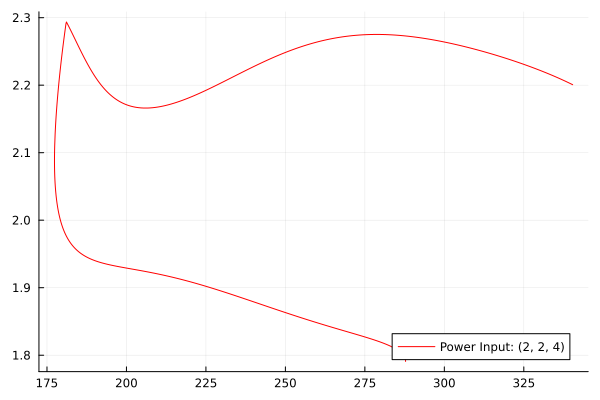

attempt to save state beyond implementation limit


In [54]:
Plots.plot(branch_tw1.param, branch_tw1.pow, label = "Power Input: (2, 2, 4)", linecolor=:red)

In [49]:
branch_tw1.param

1999-element Vector{Float64}:
 287.81193460503704
 287.81192671683624
 287.8119048444867
 287.81187466718984
 287.8115308713401
 287.8105520049555
 287.8047991363489
 287.7878943979316
 287.76383068778944
 287.69312003144245
 287.5516986944018
 287.41027734887837
 287.2688559999754
   ⋮
 338.87651050879106
 339.0179318645874
 339.15935322038274
 339.30077457617705
 339.4421959319703
 339.5836172877625
 339.7250386435536
 339.86645999934365
 339.9394068962901
 340.0808282520785
 340.2222496078658
 340.36367096365205

In [53]:
branch_tw1.pow[1]

1.790782248583893

In [52]:
size(Ψ)

(113,)

In [8]:
# # 4. Try with dissipation too
# branch_tw1_dissipation = tw_branch_continuation(
#     Ψ, A, Cx, Cz, N, x0, cx0, cz0, 200.0;
#     Re_min = 150.0,
#     Re_max = 350.0,
#     recording_function = dissipation
# )

# # 5. Plot single branch
# plt1 = plot_tw_bifurcation(
#     [branch_tw1],
#     labels = ["TW1 (2,2,4)"],
#     quantity_name = "Power Input",
#     title = "TW1 Bifurcation: Power Input vs Re"
# )
# savefig(plt1, "images/bifurcations/tw1_power.png")

# # 6. Plot phase space
# plt2 = plot_tw_phase_diagram(
#     [branch_tw1],
#     labels = ["TW1 (2,2,4)"],
#     title = "TW1 Wave Speed Evolution"
# )
# savefig(plt2, "images/bifurcations/tw1_phase.png")

# # 7. Compare multiple TWs
# Ψ_tw2, ijkl_tw2 = generate_psi_ijkl((2,2,4); symmetry=SymmetryGroup(:TW2))
# A_tw2, Cx_tw2, Cz_tw2, N_tw2 = tw_matrices(Ψ_tw2)
# x0_tw2 = vec(myreaddlm("data/continued_tws/TW2-2pi1piRe250-2-2-4-sol.asc"))

# branch_tw2 = tw_branch_continuation(
#     Ψ_tw2, A_tw2, Cx_tw2, Cz_tw2, N_tw2,
#     x0_tw2, 0.3959, 0.0, 250.0;
#     Re_min = 200.0,
#     Re_max = 350.0,
#     recording_function = power_input
# )

# plt3 = plot_tw_bifurcation(
#     [branch_tw1, branch_tw2],
#     labels = ["TW1", "TW2"],
#     quantity_name = "Power Input",
#     title = "TW Comparison"
# )
# savefig(plt3, "images/bifurcations/tw_comparison.png")

# # 8. Compare with equilibria
# # Assuming you have equilibrium branches already computed
# plt4 = compare_tw_equilibria_bifurcations(
#     [branch_tw1, branch_tw2],  # TW branches
#     [branches_122],             # Equilibrium branches from your earlier work
#     tw_labels = ["TW1", "TW2"],
#     eq_labels = ["EQ (1,2,2)"],
#     quantity_name = "Power Input",
#     title = "Traveling Waves vs Equilibria"
# )
# savefig(plt4, "images/bifurcations/tw_vs_eq.png")